## Download data, prepare environment

In [1]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

--2020-04-23 22:15:23--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 99.84.245.215, 99.84.245.170, 99.84.245.173, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|99.84.245.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.70M  60.7MB/s    in 5.1s    

2020-04-23 22:15:29 (62.6 MB/s) - ‘data.zip’ saved [333137665/333137665]



In [2]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2016_12_01_13_42_28_400.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_400.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_502.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_502.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_604.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_604.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_705.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_705.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_806.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_806.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_906.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_906.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_007.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_29_007.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_109.jpg  
  

In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

ln: failed to create symbolic link '/content/data': File exists
Updating fastai...
Done.


## Prepare data

In [0]:
import pickle
import pathlib
import random
import re
import os
from os import path

import cv2
import numpy as np
from PIL import Image
from torchvision import models

from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# Load driving_log.csv
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [0]:
# Read image paths and steering angles
images = []
measurements = []

for line in lines[1:]:
    src = 'data/{}'.format(line[0])
    image = cv2.imread(src)
    measurement = float(line[3])
    images.append(image)
    measurements.append(measurement)

In [0]:
# Data augumentation: cropping irrelevant top and bottom of camera image
for idx in range(len(images)):
    images[idx] = images[idx][50:-20,:,:]

In [0]:
# Resize to 224x224 in order to be able to be processed by pretrained ResNet18
# Additionally, apply another data augumentation: image horizontal flipping

IMG_SHAPE = (224, 224, 3)

images_resized = []
# Resize original images
for image in images:
    image_resized = cv2.resize(image, (IMG_SHAPE[0], IMG_SHAPE[1]))
    images_resized.append(image_resized)
# Prepare flipped original images
for image in images:
    image_resized = cv2.resize(image, (IMG_SHAPE[0], IMG_SHAPE[1]))
    image_resized = cv2.flip(image_resized, 1)
    images_resized.append(image_resized)

# measurements -> measurements + flipped measurements
newMeasurements = []
for measurement in measurements:
    newMeasurements.append(measurement)
for measurement in measurements:
    newMeasurements.append(-measurement)
measurements = newMeasurements

In [0]:
# Prepare numpy arrays for fast.ai 
X_train = np.array(images_resized, dtype=np.float32)
y_train = np.array(measurements, dtype=np.float32)

# Normalize and change NHWC -> NCHW [for fast.ai]
X_train = X_train / 255.0 - 0.5
y_train = y_train[:,np.newaxis]
X_train = X_train.transpose((0, 3, 1, 2))

In [0]:
# Split into train and validation datasets
VALID_RATIO = 0.1

num_all = X_train.shape[0]
num_valid = int(VALID_RATIO * num_all)
num_train = num_all - num_valid

indices = np.random.permutation(num_all)
valid_idx, training_idx = indices[:num_valid], indices[num_valid:]
X_train, X_valid = X_train[training_idx,:], X_train[valid_idx,:]
y_train, y_valid = y_train[training_idx,:], y_train[valid_idx,:]

In [0]:
# Wrap data into fast.ai DataBunch abstraction
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 1
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_ds = ArrayDataset(X_train, y_train)
valid_ds = ArrayDataset(X_valid, y_valid)

data = DataBunch.create(train_ds, valid_ds, bs=32, num_workers=1)

## Prepare ResNet18 model

We will train [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) model for the problem of behavioral cloning. ResNets are versatile models that are used with success in many different domains and form a good baseline. We use ResNet18, since it is the least powerful and expensive model that is available pretrained in torchvision library. We will retrain the model using idea of transfer learning - final dense layer (which was originally used for classification) is exchanged for dense layer that only outputs one number.

ResNet18 is supplied with standard mechanism that prevents overfitting - [Batch Normalization](https://arxiv.org/abs/1502.03167).

In [0]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)

## Prepare training and learn the model

We use fast.ai library to train the model - mean squared error is used as loss and Adam optimizer is used (by default). We also use learning rate finder provided by fast.ai to find optimal learning rate.

In [0]:
learn = Learner(data, resnet18, loss_func=mean_squared_error)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


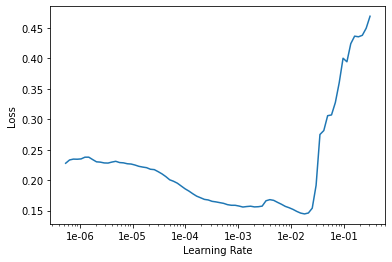

In [18]:
learn.lr_find(end_lr=2.0)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(6, max_lr=1e-2)

epoch,train_loss,valid_loss,time
0,0.019122,0.015324,00:28
1,0.017160,0.011923,00:27
2,0.016209,0.012380,00:27
3,0.010583,0.007790,00:27
4,0.010068,0.007851,00:27
5,0.009264,0.007113,00:28


Final valid loss is below 0.01, which proves to be enough to enable navigation through the test track.

## Save the final model

In [0]:
# The following line generates resnet18.pth supplied with the project
learn.save('resnet18')